## Вопросы для самопроверки:
* что такое обучени с подкреплением (reinforcement learning)?
* что такое среда?
* что такое агент?
* что такое награда, какая она может быть?

#  FrozenLake
Today you are going to learn how to survive walking over the (virtual) frozen lake through discrete optimization.

<img src="http://vignette2.wikia.nocookie.net/riseoftheguardians/images/4/4c/Jack's_little_sister_on_the_ice.jpg/revision/latest?cb=20141218030206" alt="a random image to attract attention" style="width: 400px;"/>


In [41]:
import gym

#create a single game instance
env = gym.make("FrozenLake-v0")

#start new game
env.reset();

[2017-10-22 14:38:17,831] Making new env: FrozenLake-v0


In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython import display
import numpy as np

import gym

env = gym.make("Taxi-v2")

n_states = env.observation_space.n
n_actions = env.action_space.n

[2017-10-22 14:48:55,546] Making new env: Taxi-v2


In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

def one_hot(state):
    return np.identity(n_states)[state:state+1]

In [145]:
class QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
#         x = F.relu(x)
        x = self.fc2(x)
        return x.view(x.size(0), -1)
    
def preproc_state(state):
    return Variable(torch.Tensor(one_hot(state)))

In [148]:
from itertools import count

net = QNet(n_states, 8, n_actions)
learning_rate = 0.0001
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), learning_rate)


DISCOUNT = 0.99
EPS = 0.9

n_epochs = 500
all_losses = []
all_durations = []
all_rewards = []

for epoch in range(n_epochs):
    state = env.reset()
    state = preproc_state(state)
    local_loss = 0
    local_reward = 0
    for t in count():
        q_state = net(state).data  # Predict action distribution
        
        if np.random.rand() < EPS:
            action = env.action_space.sample()
        else:
            action = q_state.topk(1)[1][0].numpy()[0]

        next_state, reward, done, _ = env.step(action)
        next_state = preproc_state(next_state)
        
        local_reward += reward

        if done:
            all_durations.append(t + 1)
            all_losses.append(local_loss / (t+1))
            all_rewards.append(local_reward)
#             print(local_loss, t+1, local_reward)
#             EPS = 1./((epoch/50) + 10)
#             EPS /= 1.0002
            EPS *= 0.99
            break
        
        q_next_state = net(next_state).data
#         print('____', q_state)
        q_state[0, action] = reward + (DISCOUNT * q_next_state.max())
#         print('+++', q_state)
            
        optimizer.zero_grad()
        output = net(state)
        loss = criterion(output, Variable(q_state))
        local_loss += loss.data[0]

        loss.backward()
        optimizer.step()

        state = next_state
    if epoch % 10 == 0:
        print('[Epoch {}] Loss {} - Reward {}'.format(epoch, all_losses[-1], all_rewards[-1]))

[Epoch 0] Loss 5.0784294940158725 - Reward -776
[Epoch 10] Loss 3.8670702506043018 - Reward -632
[Epoch 20] Loss 5.987625238464468 - Reward -740
[Epoch 30] Loss 5.43929087578319 - Reward -794
[Epoch 40] Loss 6.669853945951909 - Reward -938
[Epoch 50] Loss 5.7521111787855626 - Reward -839
[Epoch 60] Loss 4.287695458941162 - Reward -659
[Epoch 70] Loss 5.523404085598886 - Reward -794
[Epoch 80] Loss 5.2638975716754794 - Reward -767
[Epoch 90] Loss 5.478758862689137 - Reward -376


KeyboardInterrupt: 

In [142]:
net(preproc_state(6))

Variable containing:
-17.2904 -24.6634 -19.9257 -26.9219 -25.9673 -31.6336
[torch.FloatTensor of size 1x6]

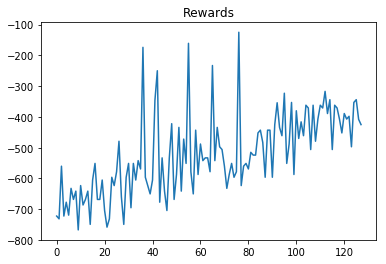

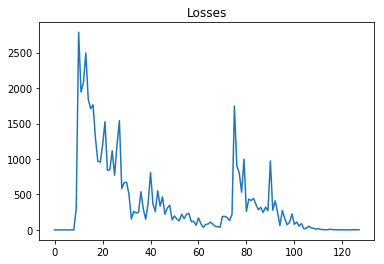

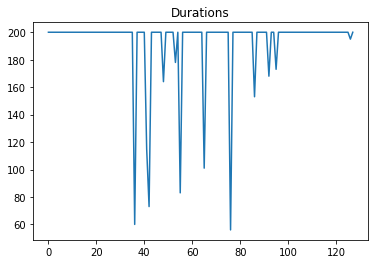

In [136]:
plt.plot(all_rewards)
plt.title('Rewards')
plt.show()

plt.plot(all_losses)
plt.title('Losses')
plt.show()

plt.plot(all_durations)
plt.title('Durations');

In [2]:
# display the game state
env.render()


SFFF
FHFH
FFFH
HFFG


### legend

![img](https://cdn-images-1.medium.com/max/800/1*MCjDzR-wfMMkS0rPqXSmKw.png)

### Gym interface

The three main methods of an environment are
* __reset()__ - reset environment to initial state, _return first observation_
* __render()__ - show current environment state (a more colorful version :) )
* __step(a)__ - commit action __a__ and return (new observation, reward, is done, info)
 * _new observation_ - an observation right after commiting the action __a__
 * _reward_ - a number representing your reward for commiting action __a__
 * _is done_ - True if the MDP has just finished, False if still in progress
 * _info_ - some auxilary stuff about what just happened. Ignore it for now

In [3]:
print("initial observation code:", env.reset())
print('printing observation:')
env.render()
print("observations:", env.observation_space, 'n=', env.observation_space.n)
print("actions:", env.action_space, 'n=', env.action_space.n)

initial observation code: 0
printing observation:

SFFF
FHFH
FFFH
HFFG
observations: Discrete(16) n= 16
actions: Discrete(4) n= 4


In [4]:
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)
print("printing new state:")
env.render()

taking action 2 (right)
new observation code: 0
reward: 0.0
is game over?: False
printing new state:
  (Right)
SFFF
FHFH
FFFH
HFFG


In [5]:
action_to_i = {
    'left':0,
    'down':1,
    'right':2,
    'up':3
}

### Play with it
* Try walking 5 steps without falling to the (H)ole
 * Bonus quest - get to the (G)oal
* Sometimes your actions will not be executed properly due to slipping over ice
* If you fall, call __env.reset()__ to restart

In [6]:
env.step(action_to_i['up'])
env.render()

  (Up)
SFFF
FHFH
FFFH
HFFG


### Baseline: random search

### Policy

* The environment has a 4x4 grid of states (16 total), they are indexed from 0 to 15
* From each states there are 4 actions (left,down,right,up), indexed from 0 to 3

We need to define agent's policy of picking actions given states. Since we have only 16 disttinct states and 4 actions, we can just store the action for each state in an array.

This basically means that any array of 16 integers from 0 to 3 makes a policy.

In [7]:
import numpy as np
n_states = env.observation_space.n
n_actions = env.action_space.n
def get_random_policy():
    """
    Build a numpy array representing agent policy.
    This array must have one element per each of 16 environment states.
    Element must be an integer from 0 to 3, representing action
    to take from that state.
    """
    return np.random.randint(0, high=n_actions, size=n_states)

In [8]:
np.random.seed(1234)
policies = [get_random_policy() for i in range(10**4)]
assert all([len(p) == n_states for p in policies]), 'policy length should always be 16'
assert np.min(policies) == 0, 'minimal action id should be 0'
assert np.max(policies) == n_actions-1, 'maximal action id should match n_actions-1'
action_probas = np.unique(policies, return_counts=True)[-1] /10**4. /n_states
print("Action frequencies over 10^4 samples:",action_probas)
assert np.allclose(action_probas, [1. / n_actions] * n_actions, atol=0.05), "The policies aren't uniformly random (maybe it's just an extremely bad luck)"
print("Seems fine!")

Action frequencies over 10^4 samples: [ 0.25014375  0.25130625  0.2495375   0.2490125 ]
Seems fine!


### Let's evaluate!
* Implement a simple function that runs one game and returns the total reward

In [9]:
from itertools import count

In [10]:
def sample_reward(env, policy, t_max=100):
    """
    Interact with an environment, return sum of all rewards.
    If game doesn't end on t_max (e.g. agent walks into a wall), 
    force end the game and return whatever reward you got so far.
    Tip: see signature of env.step(...) method above.
    """
    s = env.reset()
    total_reward = 0
    
    action = policy[s]
    
    for t in count():
        new_obs, reward, is_done, _ = env.step(action)
        total_reward += reward
        
        action = policy[new_obs]
        
        if is_done or t > t_max:
            break
    
    return total_reward

In [11]:
print("generating 10^3 sessions...")
rewards = [sample_reward(env,get_random_policy()) for _ in range(10**3)]
assert all([type(r) in (int, float) for r in rewards]), 'sample_reward must return a single number'
assert all([0 <= r <= 1 for r in rewards]), 'total rewards should be between 0 and 1 for frozenlake (if solving taxi, delete this line)'
print("Looks good!")

generating 10^3 sessions...
Looks good!


In [12]:
def evaluate(policy, n_times=100):
    """Run several evaluations and average the score the policy gets."""
    rewards = [sample_reward(env, policy) for _ in range(n_times)]
    return float(np.mean(rewards))
        

In [13]:
def print_policy(policy):
    """a function that displays a policy in a human-readable way."""
    lake = "SFFFFHFHFFFHHFFG"
    assert env.spec.id == "FrozenLake-v0", "this function only works with frozenlake 4x4"

    
    # where to move from each tile (we're a bit unsure if this is accurate)
    arrows = ['>^v<'[a] for a in policy]
    
    #draw arrows above S and F only
    signs = [arrow if tile in "SF" else tile for arrow, tile in zip(arrows, lake)]
    
    for i in range(0, 16, 4):
        print(' '.join(signs[i:i+4]))

print("random policy:")
print_policy(get_random_policy())

random policy:
v > > v
^ H v H
v < v H
H v > G


### Main loop

In [14]:
# best_policy = None
# best_score = -float('inf')

# from tqdm import tqdm
# for i in tqdm(range(10000)):
#     policy = get_random_policy()
#     score = evaluate(policy)
#     if score > best_score:
#         best_score = score
#         best_policy = policy
#         print("New best score:", score)
#         print("Best policy:")
#         print_policy(best_policy)

# Part II Genetic algorithm 

The next task is to devise some more effecient way to perform policy search.
We'll do that with a bare-bones evolutionary algorithm.
[unless you're feeling masochistic and wish to do something entirely different which is bonus points if it works]

In [15]:
def crossover(policy1, policy2, p=0.5):
    """
    for each state, with probability p take action from policy1, else policy2
    """
    new_policy = []
    for i in range(len(policy1)):
        eps = np.random.rand()
        if eps < p:
            new_policy.append(policy1[i])
        else:
            new_policy.append(policy2[i])
    return new_policy

In [16]:
def mutation(policy, p=0.1):
    """
    for each state, with probability p replace action with random action
    Tip: mutation can be written as crossover with random policy
    """
    return crossover(get_random_policy(), policy, p)

In [17]:
np.random.seed(1234)
policies = [crossover(get_random_policy(), get_random_policy()) 
            for i in range(10**4)]

assert all([len(p) == n_states for p in policies]), 'policy length should always be 16'
assert np.min(policies) == 0, 'minimal action id should be 0'
assert np.max(policies) == n_actions-1, 'maximal action id should be n_actions-1'

assert any([np.mean(crossover(np.zeros(n_states), np.ones(n_states))) not in (0, 1)
               for _ in range(100)]), "Make sure your crossover changes each action independently"
print("Seems fine!")

Seems fine!


In [18]:
n_epochs = 100 #how many cycles to make
pool_size = 50 #how many policies to maintain
n_crossovers = 50 #how many crossovers to make on each step
n_mutations = 50 #how many mutations to make on each tick

In [19]:
print("initializing...")
pool = [get_random_policy() for _ in range(pool_size)]
pool_scores = [evaluate(policy) for policy in pool]

initializing...


In [20]:
assert type(pool) == type(pool_scores) == list
assert len(pool) == len(pool_scores) == pool_size
assert all([type(score) in (float, int) for score in pool_scores])

In [21]:
#main loop
for epoch in range(n_epochs):
    print("Epoch %s:"%epoch)
    crossovered = [crossover(pool[ind1], pool[ind2])
                   for (ind1, ind2) in [np.random.choice(np.arange(len(pool)), size=2, replace=False)
                                        for _ in range(n_crossovers)]]
    mutated = [mutation(pool[np.random.choice(np.arange(len(pool)))], 0.4) for _ in range(n_mutations)]
    
    assert type(crossovered) == type(mutated) == list
    
    #add new policies to the pool
#     pool = <add up old population with crossovers/mutations>
    pool.extend(crossovered)
    pool.extend(mutated)
    pool_scores = [evaluate(policy) for policy in pool]
    #select pool_size best policies
    selected_indices = np.argsort(pool_scores)[-pool_size:]
    pool = [pool[i] for i in selected_indices]
    pool_scores = [pool_scores[i] for i in selected_indices]

    #print the best policy so far (last in ascending score order)
    print("best score:", pool_scores[-1])
    print_policy(pool[-1])

Epoch 0:
best score: 0.12
> > ^ ^
^ H v H
^ ^ > H
H < v G
Epoch 1:
best score: 0.19
> < > ^
> H ^ H
^ ^ v H
H v ^ G
Epoch 2:
best score: 0.23
^ < ^ <
> H > H
v ^ > H
H < v G
Epoch 3:
best score: 0.39
> > ^ ^
> H ^ H
< ^ ^ H
H ^ ^ G
Epoch 4:
best score: 0.57
> < ^ ^
> H ^ H
< ^ ^ H
H v ^ G
Epoch 5:
best score: 0.64
> < ^ ^
> H ^ H
< ^ ^ H
H v ^ G
Epoch 6:
best score: 0.65
> < > ^
> H v H
< ^ > H
H v v G
Epoch 7:
best score: 0.71
> < v ^
> H ^ H
< ^ > H
H v ^ G
Epoch 8:


KeyboardInterrupt: 

Ссылка на фидбек по семинару: [link](https://docs.google.com/forms/d/e/1FAIpQLSf-08wFrEke6zKlysETYiqAjH5CRXtOKut5Q77Tr5rdVId7zA/)

# Taxi

In [22]:
import gym
#create a single game instance
env = gym.make("Taxi-v2")
#start new game
env.reset();

[2017-10-22 03:23:23,051] Making new env: Taxi-v2


In [23]:
# display the game state
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [24]:
print("initial observation code:", env.reset())
print('printing observation:')
env.render()
print("observations:", env.observation_space, 'n=', env.observation_space.n)
print("actions:", env.action_space, 'n=', env.action_space.n)

initial observation code: 127
printing observation:
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

observations: Discrete(500) n= 500
actions: Discrete(6) n= 6


In [25]:
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)
print("printing new state:")
env.render()

taking action 2 (right)
new observation code: 147
reward: -1
is game over?: False
printing new state:
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


In [26]:
n_states = env.observation_space.n
n_actions = env.action_space.n

In [31]:
n_epochs = 100 #how many cycles to make
pool_size = 30 #how many policies to maintain
n_crossovers = 20 #how many crossovers to make on each step
n_mutations = 20 #how many mutations to make on each tick

print("initializing...")
pool = [get_random_policy() for _ in range(pool_size)]
pool_scores = [evaluate(policy) for policy in pool]

initializing...


In [32]:
#main loop
for epoch in range(n_epochs):
    print("Epoch %s:"%epoch)
    crossovered = [crossover(pool[ind1], pool[ind2])
                   for (ind1, ind2) in [np.random.choice(np.arange(len(pool)), size=2, replace=False)
                                        for _ in range(n_crossovers)]]
    mutated = [mutation(pool[np.random.choice(np.arange(len(pool)))]) for _ in range(n_mutations)]
    
    assert type(crossovered) == type(mutated) == list
    
    #add new policies to the pool
    pool.extend(crossovered)
    pool.extend(mutated)
    pool_scores = [evaluate(policy) for policy in pool]
    
    #select pool_size best policies
    selected_indices = np.argsort(pool_scores)[-pool_size:]
    pool = [pool[i] for i in selected_indices]
    pool_scores = [pool_scores[i] for i in selected_indices]

    #print the best policy so far (last in ascending score order)
    print("best score:", pool_scores[-1])

Epoch 0:
best score: -458.49
Epoch 1:
best score: -457.59
Epoch 2:
best score: -457.5
Epoch 3:
best score: -385.32
Epoch 4:
best score: -404.13
Epoch 5:
best score: -429.69
Epoch 6:
best score: -420.06
Epoch 7:
best score: -383.7
Epoch 8:
best score: -385.68
Epoch 9:
best score: -357.33
Epoch 10:
best score: -348.42
Epoch 11:
best score: -320.52
Epoch 12:
best score: -329.43
Epoch 13:
best score: -339.42
Epoch 14:
best score: -357.51
Epoch 15:
best score: -321.51
Epoch 16:
best score: -330.15
Epoch 17:
best score: -310.44
Epoch 18:


KeyboardInterrupt: 

In [310]:
s = env.reset()
total_reward = 0

for t in count():
    action = pool[-1][s]
    
    s, reward, is_done, _ = env.step(action)
    total_reward += reward
#     env.render()
    if is_done:
        print(t, reward)
        break

4 14
4 14
5 14
4 14
4 14
4 14
2 14
5 34
3 34
4 14
4 14
2 14
3 34
4 14
4 14
4 14
3 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
3 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
2 14
0 34
4 134
4 134
4 134
1 134
3 34
4 14
4 14
4 14
4 14
3 14
1 14
4 14
4 14
4 14
4 14
4 14
4 14
4 14
0 14
3 114
3 114
3 114
3 114
3 114
0 114
4 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
4 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
4 214
5 214
0 214
3 314
3 314
3 314
3 314
3 314
3 314
5 314
3 314
1 314
5 214
5 214
5 214
5 214
5 214
5 214
5 214
0 214
3 314
3 314
3 314
3 314
3 314
2 314
3 314
3 314
3 314
3 314
3 314
3 314
4 314
3 314
3 314
3 314
3 314
3 314
3 314
5 314
3 314
3 314
0 314
1 414
3 314
3 314
3 314
2 314
3 314
3 314
3 314
3 314
3 314
3 314
3 314
2 314
3 314
4 314
3 314
3 314
3 314
3 314
0 314
1 414
1 314
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 214
5 2